In [1]:
import os
# set the appropriate path to whichever R installation we'd like to use
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
import sys
sys.path.append('../')
from fnc_analysis import *
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from pathlib import Path
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
%%R
library(lme4)
library(lmerTest)
library(splines)
library(rstatix)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: 
Attaching package: ‘rstatix’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




In [3]:
# figure settings
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.size']= 8


fig_save_loc = Path('figures')
stat_save_loc = Path('stats/raw')
os.makedirs(fig_save_loc/'pdfs', exist_ok=True) 
os.makedirs(fig_save_loc/'svgs', exist_ok=True) 
os.makedirs(stat_save_loc, exist_ok=True) 
ctl_col = '#D4D4D4'
stim_col = '#06e1e9'

In [4]:
# load tidy data and subset dataframes for later use
data_dir = "../../../data/behavior"

#load unlimited intake
df = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/total_licks_normal_intake.csv'))
dft = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/lick_times_normal_intake.csv'))

#load limited intake
df_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/total_licks_limited_intake.csv'))
dft_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/lick_times_limited_intake.csv'))


#select fat data
#unlimited intake
df_test_f = subset_df(df, 'fat', 'test') 
dft_test_f = subset_df(dft, 'fat', 'test') 

df_train_f = subset_df(df, 'fat', 'training') 
dft_train_f = subset_df(dft, 'fat', 'training') 

#limited intake
df_test_f_ltd = subset_df(df_ltd, 'fat', 'test') 
dft_test_f_ltd = subset_df(dft_ltd, 'fat', 'test') 

df_train_f_ltd = subset_df(df_ltd, 'fat', 'training')
dft_train_f_ltd = subset_df(dft_ltd, 'fat', 'training')

## Figure 1 - unlimited intake, food deprived

In [37]:
print("\nFat:")
print("Controls: n = ", df_test_f.loc[False,].index.get_level_values('mouse').unique().size)
print("Stim: n = ",     df_test_f.loc[True, ].index.get_level_values('mouse').unique().size)


Fat:
Controls: n =  15
Stim: n =  14


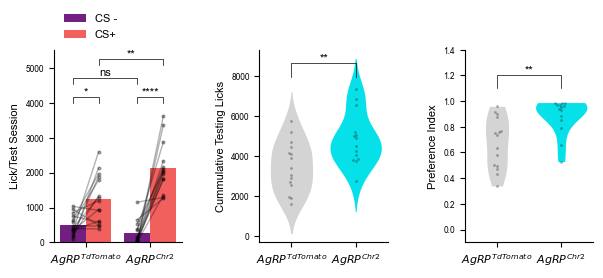

In [5]:
# create the subplot
fig, ax = plt.subplots(1,3, figsize=(6.5, 3.25))

# fat
normal_stim_f = average_test_data(df_test_f, Chr2=True)
normal_ctl_f = average_test_data(df_test_f, Chr2=False)

# plot average cs+ and cs- licks during testing
_, stats_f = two_bottle_plot(normal_stim_f, normal_ctl_f, ax=ax[0], t=60, ms=2, lw=1) 

# plot total testing licks
_, stats_f_tot = cumm_test_licks_plot(df_test_f.loc[True,],df_test_f.loc[False,],
                                      palette = [stim_col, ctl_col], ax = ax[1], ms=2)

# plot the preference indices
_, pref_f, p_pref_f = two_bottle_pref_plot_vl(df_test_f.loc[True,], df_test_f.loc[False,] , 
                                              ax=ax[2], t=60, palette = [stim_col, ctl_col], ms=2);

# ensure the limits on the y-axes are all the same
for i in range(3):
    for j in ax[i].get_yticklabels():
        j.set_fontsize(6)

        
fig.tight_layout(pad=3)

#### stats

##### stats - fat unlimited intake mean total licks during testing stats

In [6]:
df = df_test_f.groupby(['Chr2','mouse','CS']).mean(numeric_only=True).reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
test_anova_f = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2',
                              dv = 'total_licks', subject = 'mouse')

test_anova_f = test_anova_f.rename(columns = {'p-unc': 'p-value'})
test_anova_f['Significance'] = test_anova_f['p-value'].apply(check_significance)
stats_f = stats_f.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_f['Significance'] = stats_f['Corrected p-value'].apply(check_significance)


display(shapiro, levene, test_anova_f, stats_f)


statistic   p-value
Chr2  CS                     
False +    0.927676  0.251834
      -    0.943376  0.426726
True  +    0.900371  0.114190
      -    0.768113  0.002067

,statistic,p-value
CS,,
+,0.189864,0.666494
-,0.031974,0.859419


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,1.677503e+06,1,27,1.677503e+06,8.169273,8.109854e-03,0.232284,NaN,**
1,CS,2.396011e+07,1,27,2.396011e+07,61.847039,1.867697e-08,0.696107,1.0,****
2,Interaction,4.659744e+06,1,27,4.659744e+06,12.027963,1.772784e-03,0.308188,NaN,**


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,7.774430,0.000003,0.000012,13,True,****
CS+ vs. CS- $AgRP^{TdTomato}$,3.320959,0.005047,0.010069,14,True,*
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,3.457416,0.001840,0.005510,27,False,**
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,-1.975151,0.058874,0.058874,27,False,ns


##### stats - stim v control cummulative test licks comparison

In [7]:
res_f = pd.DataFrame({"statistic": [stats_f_tot[0]],
                      "df": [stats_f_tot[2]],
                      "p-value": [stats_f_tot[1]],
                      "Significance": check_significance(stats_f_tot[1])
                     }, index = ['ttest'])
display(res_f)

,statistic,df,p-value,Significance
ttest,2.854817,27,0.008225,**


##### stats - stim v control pref comparison

In [8]:
res_f = pd.DataFrame({"U": [p_pref_f[0]], 
                      "p-value": [p_pref_f[1]],
                      "Significance": check_significance(p_pref_f[1])
                     }, index = ['mann whitney u test'])

## Supplemental Figure 1 - cummulative training licks

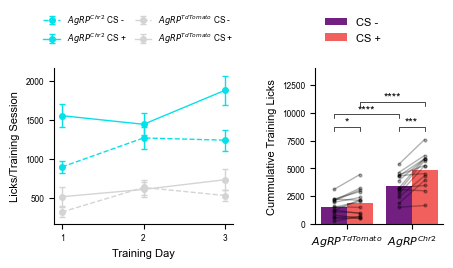

In [9]:
# get cummulative training licks for stim and control mice
cumm = df_train_f.total_licks.groupby(['Chr2','mouse','CS']).sum()
sf = cumm.loc[True,].to_frame()
cf =  cumm.loc[False,].to_frame()


# create subplot
fig, ax = plt.subplots(1,2, figsize = (5,3.25), gridspec_kw={'width_ratios': [1.4, 1]})

training_plot(df_train_f.loc[True,], df_train_f.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[0], ms=4);

_, stats_f_cumm = two_bottle_plot(sf,cf, ax = ax[1], lw=1, ms=2)

#reformat legends
ax[0].legend(*ax[0].get_legend_handles_labels(), ncol = 2,  columnspacing = 1,
            loc = 'lower left', bbox_to_anchor= (-.1,1.1), frameon = False, fontsize=6)
ax[1].legend(ax[1].get_legend().legendHandles, ['CS -', 'CS +'], 
             loc = 'lower left', bbox_to_anchor = (0,1.1), frameon=False)


#make sure the y limit is the same
ylim = 14000
ax[1].set_ylim(0,ylim)

# label axes and add titles
ax[1].set_ylabel("Cummulative Training Licks")

# fix tick font size
for i in ax.flatten():
    for j in i.get_yticklabels():
        j.set_fontsize(6)
for j in ax[0].get_xticklabels():
    j.set_fontsize(6)

fig.tight_layout(pad = 3.)


#### stats

##### stats - fat unlimited intake training


In [10]:
df = df_train_f.reset_index()

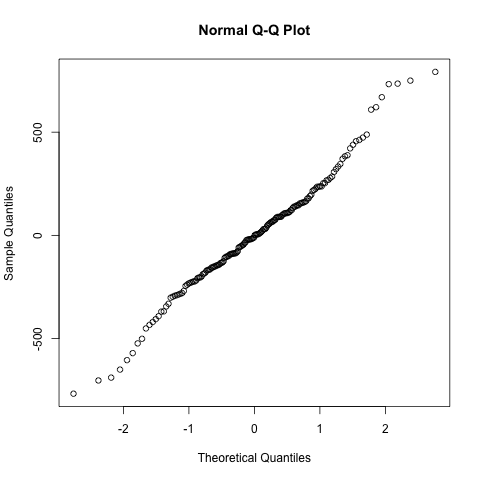

In [11]:
%%R -i df -o train_model_f -o train_anova_f
m <- lmer("total_licks ~ factor(day)*factor(CS)*factor(Chr2) + (1|mouse)", df)
train_model_f <-as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
train_anova_f <- anova(m)

In [12]:
train_model_f['Significance'] = train_model_f['Pr(>|t|)'].apply(check_significance)
train_anova_f['Significance'] = train_anova_f['Pr(>F)'].apply(check_significance)

display(train_model_f, train_anova_f)

,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),318.800000,120.410164,64.121437,2.647617,0.010190,*
factor(day)1,314.933333,113.909333,135.000000,2.764772,0.006493,**
factor(day)2,211.266667,113.909333,135.000000,1.854691,0.065822,ns
factor(CS)+,195.800000,113.909333,135.000000,1.718911,0.087923,ns
factor(Chr2)TRUE,577.914286,173.299828,64.121437,3.334765,0.001422,**
factor(day)1:factor(CS)+,-221.333333,161.092123,135.000000,-1.373955,0.171733,ns
factor(day)2:factor(CS)+,7.200000,161.092123,135.000000,0.044695,0.964417,ns
factor(day)1:factor(Chr2)TRUE,56.423810,163.943532,135.000000,0.344166,0.731257,ns
factor(day)2:factor(Chr2)TRUE,131.733333,163.943532,135.000000,0.803529,0.423082,ns
factor(CS)+:factor(Chr2)TRUE,461.557143,163.943532,135.000000,2.815342,0.005603,**


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),2.220082e+06,1.110041e+06,2,135.0,11.406679,2.647436e-05,****
factor(CS),4.113631e+06,4.113631e+06,1,135.0,42.271282,1.419396e-09,****
factor(Chr2),3.507518e+06,3.507518e+06,1,27.0,36.042929,2.095807e-06,****
factor(day):factor(CS),1.178126e+06,5.890629e+05,2,135.0,6.053155,3.036801e-03,**
factor(day):factor(Chr2),2.764846e+05,1.382423e+05,2,135.0,1.420565,2.451652e-01,ns
factor(CS):factor(Chr2),1.459447e+06,1.459447e+06,1,135.0,14.997144,1.671021e-04,***
factor(day):factor(CS):factor(Chr2),1.503688e+05,7.518441e+04,2,135.0,0.772588,4.638472e-01,ns


##### stats - fat unlimited intake cummulative training licks stats

In [13]:
df = pd.concat({True: sf['total_licks'], False: cf['total_licks']}, names = ['Chr2']).rename("total_licks").reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
cumm_train_anova_f = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', dv = 'total_licks', subject = 'mouse', correction = True)
cumm_train_anova_f = cumm_train_anova_f.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_f['Significance'] = cumm_train_anova_f['p-value'].apply(check_significance)
stats_f_cumm = stats_f_cumm.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_f_cumm['Significance'] = stats_f_cumm['Corrected p-value'].apply(check_significance)


display(shapiro, levene, cumm_train_anova_f, stats_f_cumm)

statistic   p-value
Chr2  CS                     
False +    0.923157  0.215169
      -    0.970161  0.860440
True  +    0.962867  0.769885
      -    0.972843  0.912204

,statistic,p-value
CS,,
+,0.35734,0.554969
-,1.55707,0.222809


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,8.848175e+07,1,27,8.848175e+07,36.042931,0.000002,0.571720,NaN,****
1,CS,1.185325e+07,1,27,1.185325e+07,35.853890,0.000002,0.570432,1.0,****
2,Interaction,4.378342e+06,1,27,4.378342e+06,13.243677,0.001140,0.329087,NaN,**


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,5.379634,0.000125,0.000251,13,True,***
CS+ vs. CS- $AgRP^{TdTomato}$,2.636659,0.019531,0.019531,14,True,*
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,5.909480,0.000004,0.000016,27,False,****
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,5.313762,0.000021,0.000062,27,False,****


## get lick bursts

In [14]:
_, bnf = lick_microstructure(dft_test_f, 60)
burst_f_mn = bnf.burst_num.unstack('CS').groupby(['Chr2','sex','mouse']).sum()
test_licks_f = (df_test_f.set_index('sex', append = True)
                         .total_licks
                         .unstack('CS')
                         .groupby(['Chr2','sex','mouse'])
                         .mean())
train_licks_f = (df_train_f.set_index('sex', append = True)
                           .total_licks
                           .unstack('CS')
                           .groupby(['Chr2','sex','mouse'])
                           .mean())
fb = pd.DataFrame({'tot' : burst_f_mn['+'] + burst_f_mn['-'],
                   'pref':  burst_f_mn['+']/(burst_f_mn['+'] + burst_f_mn['-']),
                   'csp_test'   : test_licks_f['+'],
                   'csm_test'   : test_licks_f['-'],
                   'csp_train'  : train_licks_f['+'],
                   'csm_train'  : train_licks_f['-']})
fb = fb.reset_index().dropna()
fb['stim'] = fb.Chr2.replace({True: r'$AgRP^{Chr2}$', False: r'$AgRP^{TdTomato}$'})
fb['cond_sex'] = fb.stim + ' ' + fb.sex

## Supplemental Figure 3 - validation of lick burst preference index

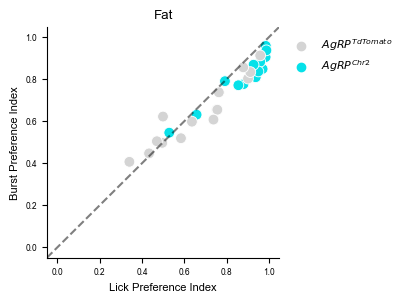

In [15]:
# create the subplot
fig, ax = plt.subplots(1,1, figsize = (3,3))


pref_f_burst = (bnf.groupby(['Chr2', 'mouse','CS'])
                   .burst_num
                   .sum()
                   .unstack('CS')
                   .apply(lambda x: pd.Series({'pref': x["+"]/(x["+"] + x["-"]),
                                               'tot': x["+"] + x["-"]}), axis=1)
                   .reset_index()
               )
pref_f_burst['Condition'] = pref_f_burst.Chr2.replace({False: r"$AgRP^{TdTomato}$", True: r"$AgRP^{Chr2}$"})
pref_f_burst = pref_f_burst.set_index(["Condition","mouse"])

# plot preference index computed from bursts vs those computed from licks
pref_f_comb = pd.concat({'Lick Preference Index': pref_f.pref, 
                        'Burst Preference Index': pref_f_burst.pref}, axis=1)
sns.scatterplot(data = pref_f_comb.reset_index(), x = 'Lick Preference Index',
                y = 'Burst Preference Index', hue = 'Condition', 
                hue_order = [r'$AgRP^{TdTomato}$', r'$AgRP^{Chr2}$'],
                s = 60, palette = [ctl_col, stim_col], ax = ax) 

ax.plot([-.05,1.05],[-.05,1.05], ls = '--', c = 'k', alpha=.5)
ax.set_xlim([-.05,1.05])
ax.set_ylim([-.05,1.05])
ax.set_title('Fat')

# format legend text
ax.legend(loc = 'upper left', bbox_to_anchor = (1,1), frameon = False, title = "")

for j in ax.get_xticklabels() + ax.get_yticklabels() :
        j.set_fontsize(6)

        
# remove bottom roww legends
sns.despine()

#### stats

##### stats - unlimited inntake lick burst preference vs lick preference stats

In [16]:
f_corr_stats = pd.DataFrame({'Signed Rank': st.wilcoxon(pref_f_burst.sort_index().pref.values, pref_f.sort_index().pref.values),
                              'Spearman Correlation': st.spearmanr(pref_f_burst.sort_index().pref.values, pref_f.sort_index().pref.values)},
                              index =  ('statistic', 'p-value')).T
f_corr_stats['Significance'] = f_corr_stats['p-value'].apply(check_significance)

display(f_corr_stats)

,statistic,p-value,Significance
Signed Rank,59.000000,2.992637e-04,***
Spearman Correlation,0.966995,1.455248e-17,****


## Figure 2 - training v testing correlation

### model fitting

,VIF Factor,features
0,6.964811,Intercept
1,7.927447,C(Chr2)[T.True]
2,5.860516,csp_train
3,16.879001,C(Chr2)[T.True]:csp_train


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.0625,0.09,0.691,0.489,-0.115,0.240,ns
C(Chr2)[T.True],0.4462,0.19,2.354,0.019,0.075,0.818,*
csp_train,0.0011,0.00,8.276,0.000,0.001,0.001,****
C(Chr2)[T.True]:csp_train,-0.0005,0.00,-3.090,0.002,-0.001,-0.000,**


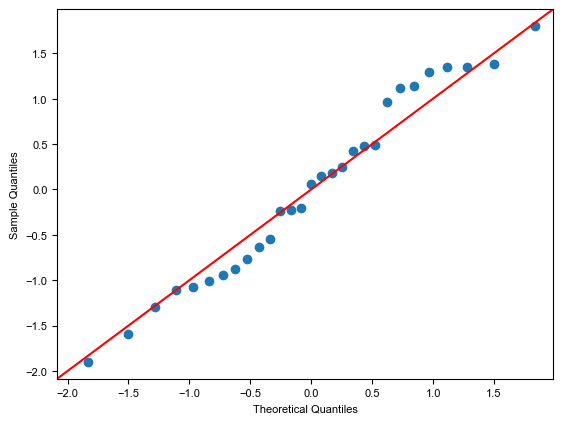

In [17]:
model_eq = 'pref ~ (C(Chr2))*csp_train'
y, X = dmatrices(model_eq, fb, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
display(vif)

model_fb = smf.glm(model_eq, data = fb, 
                   family = sm.families.Binomial(), 
                   freq_weights = fb.tot).fit()

model_fb_summ =pd.DataFrame(model_fb.summary().tables[1])
model_fb_summ.columns = model_fb_summ.iloc[0].astype(str)
model_fb_summ = model_fb_summ.set_index('').iloc[1:].astype(str).astype(float)
model_fb_summ['Significance'] = model_fb_summ['P>|z|'].apply(check_significance)
model_fb_pseudo_r2 = pd.DataFrame({"R2":model_fb.pseudo_rsquared()}, index=("Cox-Snell R2",))

display(model_fb_summ)
sm.qqplot(model_fb.resid_deviance, fit=True, line='45');

#### separate models for control and stim 

,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.5087,0.167,3.053,0.002,0.182,0.835,**
csp_train,0.0006,0.000,5.274,0.000,0.000,0.001,****


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.0625,0.09,0.691,0.489,-0.115,0.240,ns
csp_train,0.0011,0.00,8.276,0.000,0.001,0.001,****


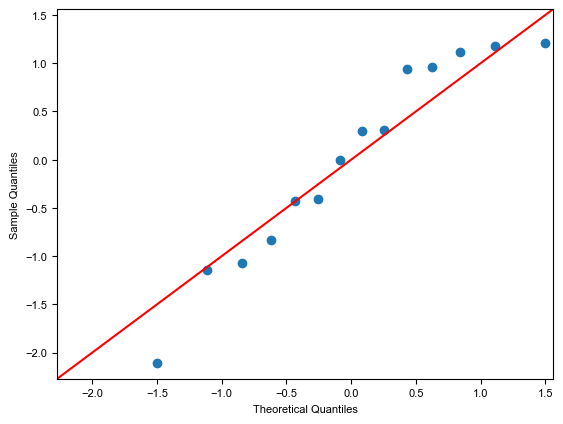

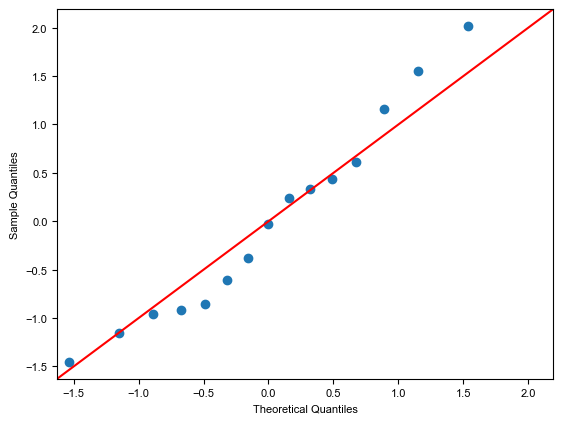

In [18]:
model_eq = 'pref ~ 1 + csp_train'

model_fb_stim = smf.glm(model_eq, data = fb.loc[fb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = fb.loc[fb.Chr2].tot).fit()
model_fb_stim_summ =pd.DataFrame(model_fb_stim.summary().tables[1])
model_fb_stim_summ.columns = model_fb_stim_summ.iloc[0].astype(str)
model_fb_stim_summ = model_fb_stim_summ.set_index('').iloc[1:].astype(str).astype(float)
model_fb_stim_pseudo_r2 = pd.DataFrame({"R2": model_fb_stim.pseudo_rsquared()}, index=("Cox-Snell R2",))
model_fb_stim_summ['Significance'] = model_fb_stim_summ['P>|z|'].apply(check_significance)
sm.qqplot(model_fb_stim.resid_deviance, fit=True, line='45');



model_fb_ctl = smf.glm(model_eq, data = fb.loc[~fb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = fb.loc[~fb.Chr2].tot).fit()
model_fb_ctl_summ =pd.DataFrame(model_fb_ctl.summary().tables[1])
model_fb_ctl_summ.columns = model_fb_ctl_summ.iloc[0].astype(str)
model_fb_ctl_summ = model_fb_ctl_summ.set_index('').iloc[1:].astype(str).astype(float)
model_fb_ctl_summ['Significance'] = model_fb_ctl_summ['P>|z|'].apply(check_significance)
model_fb_ctl_pseudo_r2 = pd.DataFrame({"R2": model_fb_ctl.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_fb_ctl.resid_deviance, fit=True, line='45');


display(model_fb_stim_summ, model_fb_ctl_summ)

### main plots - correlations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


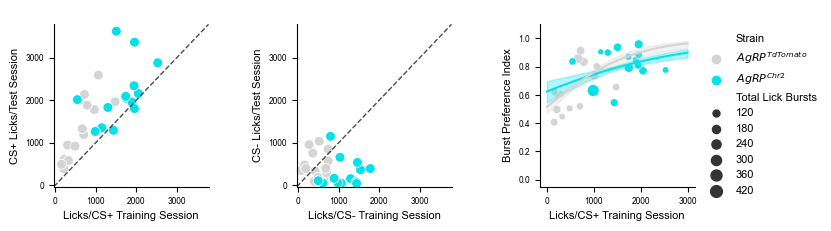

In [19]:
# create the subplot
fig, ax = plt.subplots(1, 3, figsize = (9,3))

sns.scatterplot(data = fb, x='csp_train', y= 'csp_test', hue='stim', 
                hue_order = [r'$AgRP^{TdTomato}$', r'$AgRP^{Chr2}$'],
                legend = False, palette = [ ctl_col, stim_col], s=50, ax=ax[0]);
sns.scatterplot(data = fb, x='csm_train', y= 'csm_test', hue='stim',
                hue_order = [r'$AgRP^{TdTomato}$', r'$AgRP^{Chr2}$'],
                legend = False, palette = [ ctl_col, stim_col], s=50, ax=ax[1]);

ax[0].legend(loc = 'lower left', bbox_to_anchor = (0,1), frameon = False, title = "")


# determine common x and y limits for all plots
xlims = np.array([ ax[i].get_xlim() for i in range(2)])
ylims = np.array([ ax[i].get_ylim() for i in range(2)])
lims = np.concatenate((xlims, ylims), axis=0)
bnd = (lims[:,0].min(), lims[:,1].max())

# plot the diagonal for scatter plots
ax[0].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)
ax[1].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)


# plot preference vs training licks
sns.scatterplot(data = fb.rename(columns={'tot': 'Total Lick Bursts', 'stim': 'Strain'}), 
                x='csp_train', y= 'pref', hue='Strain', legend = True, size='Total Lick Bursts',
                palette = [ ctl_col, stim_col], s=100, ax=ax[2]);
sns.move_legend(ax[2], loc='upper left', bbox_to_anchor = (1,1), frameon = False)

# get model predictions separately for stim and control mice
x = np.linspace(0,3000,1000) # test values
pred_stim_f = model_fb.get_prediction({'Chr2': [True]*x.size, 'csp_train': x})
pred_ctl_f= model_fb.get_prediction({'Chr2': [False]*x.size, 'csp_train': x})

# plot the model predictions
ax[2].plot(x, pred_stim_f.predicted_mean, c=stim_col)
ax[2].fill_between(x, pred_stim_f.conf_int()[:,0], 
                     pred_stim_f.conf_int()[:,1], 
                     alpha=.3, color = stim_col)
ax[2].plot(x,  pred_ctl_f.predicted_mean, c =ctl_col)
ax[2].fill_between(x, pred_ctl_f.conf_int()[:,0], 
                     pred_ctl_f.conf_int()[:,1], 
                     alpha=.3,color=ctl_col)

# label axes and set the axis limits
ax[0].set(ylabel = "CS+ Licks/Test Session", 
            xlabel = "Licks/CS+ Training Session",
            xlim  = bnd, ylim = bnd)
ax[1].set(ylabel = "CS- Licks/Test Session", 
            xlabel = "Licks/CS- Training Session",
            xlim  = bnd, ylim = bnd)

ax[2].set(xlabel = 'Licks/CS+ Training Session',
            ylabel = 'Burst Preference Index',
            ylim = (-.05,1.1))

for i in ax.flatten():
    for j in i.get_xticklabels() + i.get_yticklabels() :
        j.set_fontsize(6)
        
# format plots
sns.despine()
fig.tight_layout(pad = 4)

#### stats

##### stats - fat unlimited intake training vs testing licks correlation

In [20]:
r_csp, p_csp = st.pearsonr(fb['csp_train'], fb['csp_test'])
r_csm, p_csm = st.pearsonr(fb['csm_train'], fb['csm_test'])
corr_f_p = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csp, p_csp, check_significance(p_csp)]},
                      index = ('Pearson R', 'p-value', 'Significance')).T

corr_f_m = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csm, p_csm, check_significance(p_csm)]} ,
                      index = ('Pearson R', 'p-value', 'Significance')).T

display(corr_f_p, corr_f_m )

,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,0.757673,0.000002,****


,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,-0.223758,0.243276,ns


### sex differences

,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,-0.4471,0.129,-3.459,0.001,-0.700,-0.194,**
C(Chr2)[T.True],3.8261,0.630,6.071,0.000,2.591,5.061,****
csp_train,0.0020,0.000,10.106,0.000,0.002,0.002,****
C(Chr2)[T.True]:csp_train,-0.0028,0.000,-7.469,0.000,-0.004,-0.002,****


,R2
Cox-Snell R2,1.0


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.4466,0.128,3.496,0.000,0.196000,0.697000,****
C(Chr2)[T.True],0.4568,0.233,1.961,0.050,0.000000,0.913000,ns
csp_train,0.0004,0.000,2.235,0.025,0.000045,0.001000,*
C(Chr2)[T.True]:csp_train,-0.0003,0.000,-1.530,0.126,-0.001000,0.000095,ns


,R2
Cox-Snell R2,0.58904


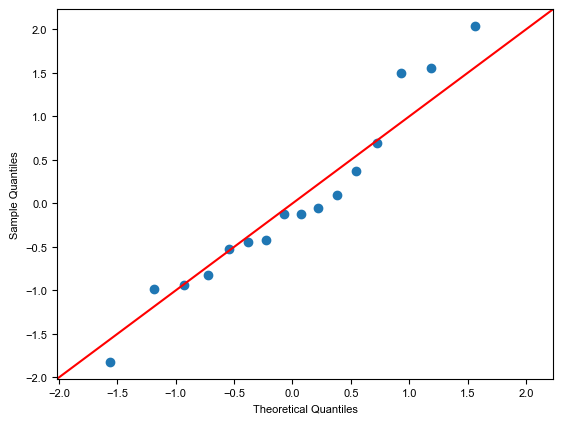

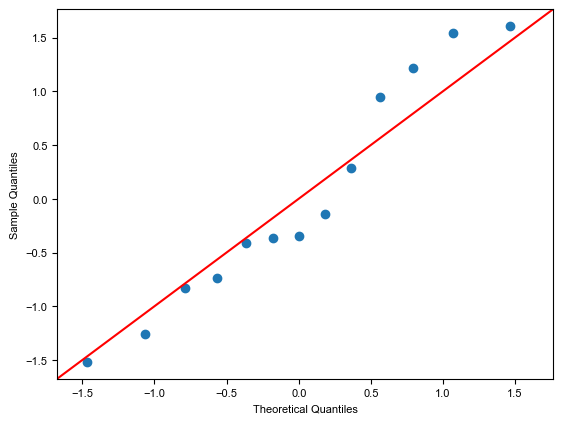

In [21]:
model_eq = 'pref ~ 1 + C(Chr2)*csp_train'

model_fm = smf.glm(model_eq, data = fb.loc[fb.sex=='M'], 
                    family = sm.families.Binomial(), 
                    freq_weights = fb.loc[fb.sex=='M'].tot).fit()
model_fm_summ =pd.DataFrame(model_fm.summary().tables[1])
model_fm_summ.columns = model_fm_summ.iloc[0].astype(str)
model_fm_summ = model_fm_summ.set_index('').iloc[1:].astype(str).astype(float)
model_fm_summ['Significance'] = model_fm_summ['P>|z|'].apply(check_significance)
model_fm_pseudo_r2 = pd.DataFrame({"R2": model_fm.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_fm.resid_deviance, fit=True, line='45');



model_ff = smf.glm(model_eq, data = fb.loc[fb.sex=='F'], 
                    family = sm.families.Binomial(), 
                    freq_weights = fb.loc[fb.sex=='F'].tot).fit()
model_ff_summ =pd.DataFrame(model_ff.summary().tables[1])
model_ff_summ.columns = model_ff_summ.iloc[0].astype(str)
model_ff_summ = model_ff_summ.set_index('').iloc[1:].astype(str).astype(float)
model_ff_summ['Significance'] = model_ff_summ['P>|z|'].apply(check_significance)
model_ff_pseudo_r2 = pd.DataFrame({"R2": model_ff.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_ff.resid_deviance, fit=True, line='45');

display(model_fm_summ, model_fm_pseudo_r2, model_ff_summ, model_ff_pseudo_r2)

### main plot - sex differences

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_72979/2929274792.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


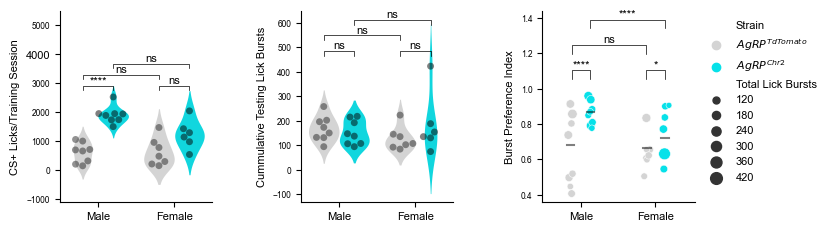

In [22]:
# create subplot
fig, ax = plt.subplots(1,3, figsize = (9,3))

# plot training licks split by strain and sex
g, train_sex_diff_stats_f = plot_sex_diff(fb, 'csp_train', ax=ax[0], palette = [ctl_col, stim_col], ylabel = "CS+ Licks/Training Session")
g.get_legend().remove()
# plot total test licks split by strain and sex
g, test_sex_diff_stats_f =  plot_sex_diff(fb, 'tot', ax=ax[1], palette = [ctl_col, stim_col], ylabel = "Cummulative Testing Lick Bursts")
g.get_legend().remove()
# plot preference split by strain and sex
_, pref_sex_diff_stats_f = plot_sex_diff_pref(fb, ax=ax[2], palette = [ctl_col, stim_col])

# adjust axis limits
for j in range(2):
    ax[j].set_xlim(-.5,1.5)

for i in ax.flatten(): 
    for j in i.get_yticklabels():
        j.set_fontsize(6)    

# format the plots
ax[0].set_ylim(-1100, 5500)
sns.despine()
fig.tight_layout(pad = 4)
fig.show()

#### stats

##### stats - train licks

,Source,SS,DF,MS,F,p-unc,np2,Significance
0,sex,6.771580e+05,1.0,6.771580e+05,4.168204,5.187614e-02,0.142902,ns
1,Chr2,7.165456e+06,1.0,7.165456e+06,44.106524,5.857136e-07,0.638240,****
2,sex * Chr2,8.422965e+05,1.0,8.422965e+05,5.184705,3.160684e-02,0.171766,*
3,Residual,4.061449e+06,25.0,1.624580e+05,NaN,NaN,NaN,ns


,comparison,Chr2,t,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,-0.097060,0.924455,13.0,NaN,0.924455,ns
1,Male vs Female,True,2.903557,0.020972,12.0,NaN,0.061607,ns
2,Stim vs Control,NaN,2.259667,0.046159,11.0,F,0.090187,ns
3,Stim vs Control,NaN,8.111882,0.000001,14.0,M,0.000006,****


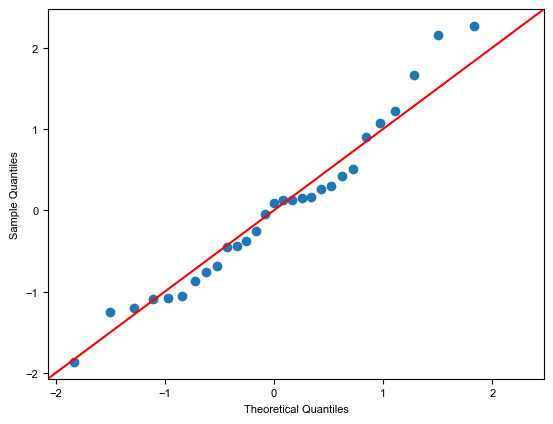

In [23]:
model = smf.ols('csp_train ~ C(sex, Sum)*C(Chr2, Sum)', data=fb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_train_sex_diff_f = pg.anova(data = fb, dv = 'csp_train', between = ['sex', 'Chr2'])
anova_train_sex_diff_f['Significance'] = anova_train_sex_diff_f['p-unc'].apply(check_significance)
train_sex_diff_stats_f['Significance'] = train_sex_diff_stats_f['Corrected p-value'].apply(check_significance)

display(anova_train_sex_diff_f, train_sex_diff_stats_f)

##### stats - total test bursts

,Source,SS,DF,MS,F,p-unc,np2,Significance
0,sex,225.109625,1.0,225.109625,0.044893,0.833919,0.001793,ns
1,Chr2,2147.626841,1.0,2147.626841,0.428296,0.518802,0.016843,ns
2,sex * Chr2,9301.823708,1.0,9301.823708,1.855039,0.185346,0.069076,ns
3,Residual,125358.857143,25.0,5014.354286,NaN,NaN,NaN,ns


,comparison,Chr2,t,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,1.566112,0.141449,13.0,NaN,0.456669,ns
1,Male vs Female,True,-0.601439,0.568663,12.0,NaN,0.810450,ns
2,Stim vs Control,NaN,1.072004,0.323098,11.0,F,0.689846,ns
3,Stim vs Control,NaN,-0.589955,0.564627,14.0,M,0.810450,ns


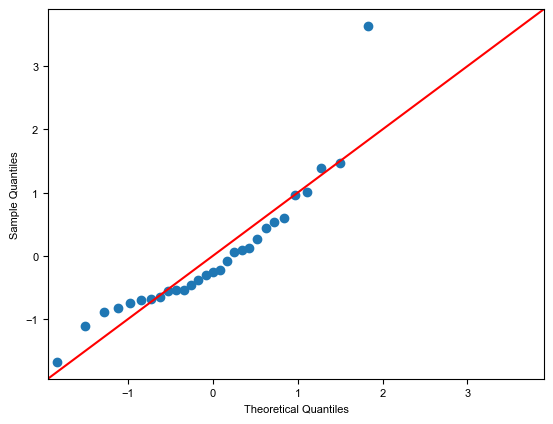

In [24]:
model = smf.ols('tot ~ C(sex, Sum)*C(Chr2, Sum)', data=fb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_test_sex_diff_f = pg.anova(data = fb, dv = 'tot', between = ['sex', 'Chr2'])
anova_test_sex_diff_f['Significance'] = anova_test_sex_diff_f['p-unc'].apply(check_significance)
test_sex_diff_stats_f['Significance'] = test_sex_diff_stats_f['Corrected p-value'].apply(check_significance)

display(anova_test_sex_diff_f, test_sex_diff_stats_f)

In [25]:
%%R -i fb -o pref_anova_f
pref_anova_f <- anova(glm('pref ~ factor(sex)*factor(Chr2)', data = fb, family = binomial, weights = tot), test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi),Significance
NULL,-2147483648,NaN,28,581.767587,NaN,ns
factor(sex),1,33.200700,27,548.566887,8.312059e-09,****
factor(Chr2),1,95.833153,26,452.733734,1.249851e-22,****
factor(sex):factor(Chr2),1,37.952691,25,414.781043,7.248102e-10,****


,comparison,Chr2,coef,z,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,0.077823,0.843409,3.989996e-01,2222.0,NaN,3.989996e-01,ns
1,Male vs Female,True,0.943861,8.750148,2.130731e-18,2318.0,NaN,6.392194e-18,****
2,Stim vs Control,NaN,0.247946,2.539134,1.111271e-02,1990.0,F,2.210193e-02,*
3,Stim vs Control,NaN,1.113985,10.812827,2.993011e-27,2550.0,M,1.197204e-26,****


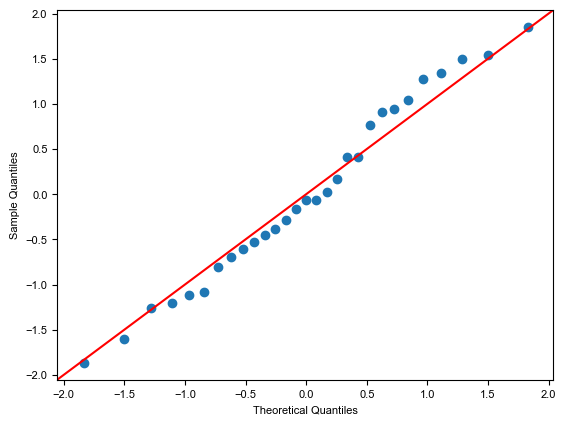

In [26]:
model = smf.glm('pref ~ 1 +  C(sex)*C(Chr2)', data = fb, freq_weights = fb.tot, family = sm.families.Binomial()).fit()
sm.qqplot(model.resid_deviance, fit=True, line='45');
pref_anova_f['Significance'] = pref_anova_f['Pr(>Chi)'].apply(check_significance)
pref_sex_diff_stats_f['Significance'] = pref_sex_diff_stats_f['Corrected p-value'].apply(check_significance)

display(pref_anova_f, pref_sex_diff_stats_f)

# limited intake, food deprived

## Figure 3 - limited intake

In [27]:
print("Controls: n = ",df_test_f_ltd.loc[False,].index.get_level_values('mouse').unique().size)
print("Stim: n = ", df_test_f_ltd.loc[True,].index.get_level_values('mouse').unique().size)

Controls: n =  7
Stim: n =  7


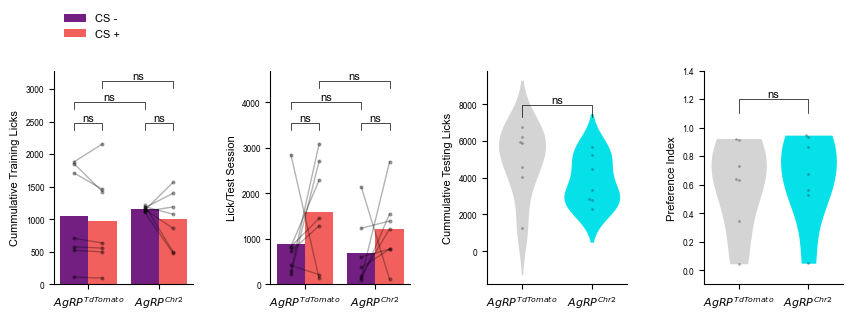

In [28]:
# create subplot
fig, ax = plt.subplots(1,4, figsize=(9,3.75))


# get cummulative training licks for stim and control mice

cumm = df_train_f_ltd.total_licks.groupby(['Chr2','mouse','CS']).sum()
sf = cumm.loc[True,].to_frame()
cf =  cumm.loc[False,].to_frame()

# get the average stim and control testing licks for CS+ vs CS- flavors
ltd_stim_f = average_test_data(df_test_f_ltd, Chr2=True)
ltd_ctl_f = average_test_data(df_test_f_ltd, Chr2=False)
_, stats_f_cumm_ltd = two_bottle_plot(sf,cf, ax = ax[0], ms=2, lw=1)

#reformat legends
ax[0].legend(ax[0].get_legend().legendHandles, ['CS -', 'CS +'], 
             loc = 'lower left', bbox_to_anchor = (0,1.1), frameon=False)

# label axes and add titles
ax[0].set_ylabel("Cummulative Training Licks", fontsize=8)

# plot average CS+ and CS- testing licks for stim and control mice
_, stats_f_ltd = two_bottle_plot(ltd_stim_f, ltd_ctl_f, ax=ax[1], t = 60, ms=2, lw=1);

# plot total licks
_, stats_cumm_ltd_f = cumm_test_licks_plot(df_test_f_ltd.loc[True,], df_test_f_ltd.loc[False,],
                     palette = [stim_col, ctl_col], ax = ax[2], ms=2)

# plot cummulative pref index for stim vs control
_, _, p_pref_ltd_f = two_bottle_pref_plot_vl(df_test_f_ltd.loc[True,], df_test_f_ltd.loc[False,] , 
                                     ax=ax[3], palette = [stim_col, ctl_col,], t = 60, ms=2);

# remove legends
ax[1].get_legend().remove()



for i in ax.flatten():
    for j in i.get_yticklabels() :
        j.set_fontsize(6)

fig.tight_layout(pad=3.)


#### stats

##### stats - fat limited intake cummulative training licks

In [29]:
df = df_train_f_ltd.groupby(['Chr2','mouse','CS']).sum(numeric_only = True).reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
cumm_train_anova_f_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', 
                                        dv = 'total_licks', subject = 'mouse')
cumm_train_anova_f_ltd = cumm_train_anova_f_ltd.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_f_ltd['Significance'] = cumm_train_anova_f_ltd['p-value'].apply(check_significance)
stats_f_cumm_ltd = stats_f_cumm_ltd.rename(columns = {'statistic': 't', 
                                                      'pvalue': 'p-value', 
                                                      'pvalue_corr': 'Corrected p-value'})
stats_f_cumm_ltd['Significance'] = stats_f_cumm_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, cumm_train_anova_f_ltd, stats_f_cumm_ltd)

statistic   p-value
Chr2  CS                     
False +    0.922997  0.493032
      -    0.848585  0.119288
True  +    0.934970  0.593917
      -    0.968339  0.886235

,statistic,p-value
CS,,
+,1.024989,0.331318
-,8.939191,0.011277


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,35358.035714,1,12,35358.035714,0.062784,0.806388,0.005205,NaN,ns
1,CS,86802.892857,1,12,86802.892857,1.533583,0.239255,0.113317,1.0,ns
2,Interaction,8540.035714,1,12,8540.035714,0.150880,0.704499,0.012417,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,-0.915033,0.395459,0.860903,6,True,ns
CS+ vs. CS- $AgRP^{TdTomato}$,-0.927824,0.389298,0.860903,6,True,ns
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,0.114814,0.910951,0.920056,12,False,ns
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,0.379587,0.717257,0.920056,12,False,ns


##### stats - fat unlimited intake mean total licks during testing stats

In [30]:
df = df_test_f_ltd.groupby(['Chr2','mouse','CS']).mean(numeric_only=True).reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
test_anova_f_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2',
                                  dv = 'total_licks', subject = 'mouse')
test_anova_f_ltd = test_anova_f_ltd.rename(columns = {'p-unc': 'p-value'})
test_anova_f_ltd['Significance'] = test_anova_f_ltd['p-value'].apply(check_significance)
stats_f_ltd = stats_f_ltd.rename(columns = {'statistic': 't', 
                                            'pvalue': 'p-value', 
                                            'pvalue_corr': 'Corrected p-value'})
stats_f_ltd['Significance'] = stats_f_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, test_anova_f_ltd, stats_f_ltd)

statistic   p-value
Chr2  CS                     
False +    0.924514  0.505270
      -    0.704063  0.004105
True  +    0.947445  0.706395
      -    0.808335  0.049478

,statistic,p-value
CS,,
+,1.307637,0.275123
-,0.000387,0.984619


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,5.819047e+05,1,12,5.819047e+05,1.742871,0.211404,0.126820,NaN,ns
1,CS,2.715346e+06,1,12,2.715346e+06,1.998603,0.182859,0.142772,1.0,ns
2,Interaction,5.957044e+04,1,12,5.957044e+04,0.043846,0.837653,0.003641,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Chr2}$,0.994549,0.358357,0.818409,6,True,ns
CS+ vs. CS- $AgRP^{TdTomato}$,1.019706,0.347210,0.818409,6,True,ns
CS+ $AgRP^{Chr2}$ vs. CS+ $AgRP^{TdTomato}$,-0.711154,0.492169,0.818409,12,False,ns
CS- $AgRP^{Chr2}$ vs. CS- $AgRP^{TdTomato}$,-0.441542,0.666937,0.818409,12,False,ns


##### stats - limited intake cummulative testing licks

In [31]:
res_f = pd.DataFrame({"statistic": [stats_cumm_ltd_f[0]],
                      "df": [stats_cumm_ltd_f[2]],
                      "p-value": [stats_cumm_ltd_f[1]],
                      "Significance": check_significance(stats_cumm_ltd_f[1])
                     }, index = ['ttest'])

print("fat")
display(res_f)

fat


,statistic,df,p-value,Significance
ttest,-1.320178,12,0.214068,ns


##### stats - stim v control pref comparison

In [32]:
res_f = pd.DataFrame({"U": [p_pref_ltd_f[0]], 
                      "p-value": [p_pref_ltd_f[1]],
                      "Significance": check_significance(p_pref_ltd_f[1])
                     }, index = ['mann whitney u test'])

print("fat")
display(res_f)

fat


,U,p-value,Significance
mann whitney u test,28.0,0.710373,ns


### sex differences

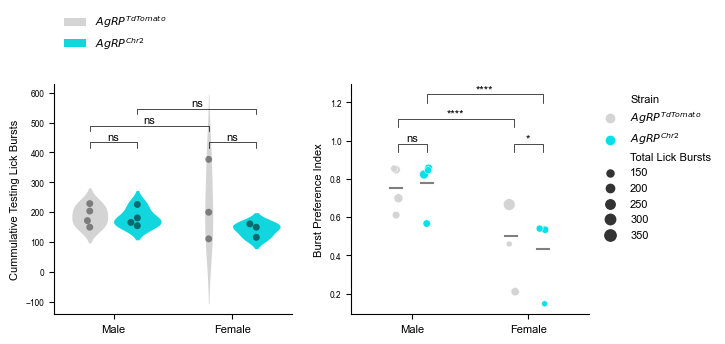

In [33]:
#get burst numbers for burst preference indices
bnf_ltd = lick_microstructure(dft_test_f_ltd, 60)[1]

#get preferences
pref_ltd_f =  bnf_ltd.groupby(['Chr2', 'sex', 'mouse', 'CS']).burst_num.sum().unstack('CS')
pref_ltd_f =  pd.concat({'tot': pref_ltd_f.sum(axis=1), 'pref': pref_ltd_f['+']/pref_ltd_f.sum(axis=1)}, axis=1).reset_index()

fig, ax = plt.subplots(1,2, figsize = (7.5,3.75))

_, test_sex_diff_ltd_stats_f = plot_sex_diff(pref_ltd_f, 'tot', ax=ax[0], palette = [ctl_col, stim_col], ylabel='Cummulative Testing Lick Bursts')
ax[0].set_xlim(-.5, 1.5)
_, pref_sex_diff_ltd_stats_f = plot_sex_diff_pref(pref_ltd_f, ax=ax[1], palette = [ctl_col, stim_col] )

sns.despine()
for i in ax.flatten():
    for j in i.get_yticklabels() :
            j.set_fontsize(6)
fig.tight_layout(pad=2.)

#### stats

##### stats - total lick bursts

,Source,SS,DF,MS,F,p-unc,np2,Significance
0,sex,0.720238,1.0,0.720238,0.000162,0.990080,0.000016,ns
1,Chr2,5924.571429,1.0,5924.571429,1.336588,0.274510,0.117900,ns
2,sex * Chr2,5520.053571,1.0,5520.053571,1.245329,0.290544,0.110742,ns
3,Residual,44326.083333,10.0,4432.608333,NaN,NaN,NaN,ns


,comparison,Chr2,t,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,-0.506724,0.658623,5.0,NaN,0.883461,ns
1,Male vs Female,True,1.919729,0.113180,5.0,NaN,0.381496,ns
2,Stim vs Control,NaN,-1.096542,0.381684,4.0,F,0.763608,ns
3,Stim vs Control,NaN,-0.288769,0.782587,6.0,M,0.883461,ns


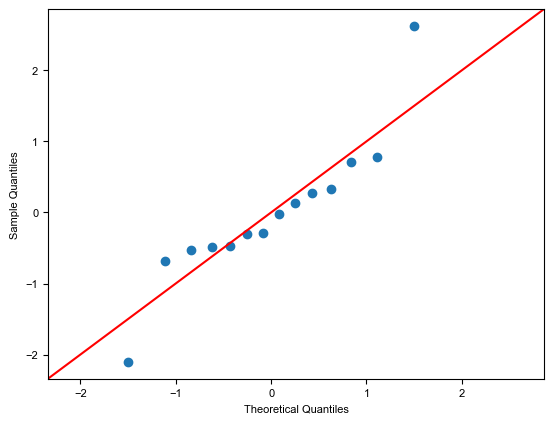

In [34]:
model = smf.ols('tot ~ C(sex, Sum)*C(Chr2, Sum)', data=pref_ltd_f).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_test_sex_diff_ltd_f = pg.anova(data = pref_ltd_f, dv = 'tot', between = ['sex', 'Chr2'])
anova_test_sex_diff_ltd_f['Significance'] = anova_test_sex_diff_ltd_f['p-unc'].apply(check_significance)
test_sex_diff_ltd_stats_f['Significance'] = test_sex_diff_ltd_stats_f['Corrected p-value'].apply(check_significance)

display(anova_test_sex_diff_ltd_f,  test_sex_diff_ltd_stats_f)

##### stats - burst preference index

In [35]:
%%R -i pref_ltd_f -o pref_anova_ltd_f
pref_anova_ltd_f <- anova(glm('pref ~ factor(sex)*factor(Chr2)', data = pref_ltd_f, family = binomial, weights = tot), test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi),Significance
NULL,-2147483648,NaN,13,503.108243,NaN,ns
factor(sex),1,232.612857,12,270.495386,1.605224e-52,****
factor(Chr2),1,0.470298,11,270.025088,4.928503e-01,ns
factor(sex):factor(Chr2),1,6.172014,10,263.853075,1.297868e-02,*


,comparison,Chr2,coef,z,p-value,df,sex,Corrected p-value,Significance
0,Male vs Female,False,1.096847,9.667794,4.131872e-22,1441.0,NaN,1.239562e-21,****
1,Male vs Female,True,1.529123,11.562513,6.381355e-31,1153.0,NaN,2.552542e-30,****
2,Stim vs Control,NaN,-0.278126,-2.243828,2.484347e-02,1113.0,F,4.906973e-02,*
3,Stim vs Control,NaN,0.154151,1.258744,2.081229e-01,1481.0,M,2.081229e-01,ns


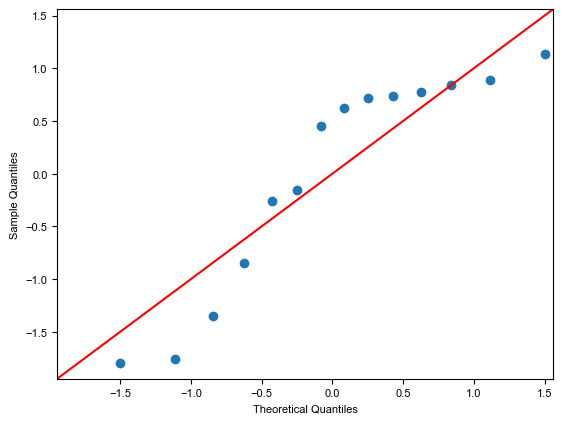

In [36]:
model = smf.glm('pref ~ 1 +  C(sex)*C(Chr2)', data = pref_ltd_f, freq_weights = pref_ltd_f.tot, family = sm.families.Binomial()).fit()
sm.qqplot(model.resid_deviance, fit=True, line='45');
pref_anova_ltd_f['Significance'] = pref_anova_ltd_f['Pr(>Chi)'].apply(check_significance)
pref_sex_diff_ltd_stats_f['Significance'] = pref_sex_diff_ltd_stats_f['Corrected p-value'].apply(check_significance)


display(pref_anova_ltd_f, pref_sex_diff_ltd_stats_f)